# Proyecto Final – Predicción de RUL con CMAPSS (Aprendizaje Supervisado)

**Autor:** Sebastián Marinovic  
**Curso:** (tu curso)  
**Fecha:** (fecha)

## Objetivo
Desarrollar un modelo de *aprendizaje supervisado* para predecir el **Remaining Useful Life (RUL)** de motores a partir de señales de sensores y variables operacionales (dataset CMAPSS).  
Se comparan **3 modelos**, se ajustan hiperparámetros con **GridSearchCV**, y se reportan métricas de desempeño (MAE/RMSE/R²).


In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import GroupKFold, GroupShuffleSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

import matplotlib.pyplot as plt


In [2]:
train = pd.read_csv("train_FD001.txt", sep=r"\s+", header=None)
test  = pd.read_csv("test_FD001.txt",  sep=r"\s+", header=None)
rul   = pd.read_csv("RUL_FD001.txt",   sep=r"\s+", header=None)



In [3]:
train.head()


,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [4]:
train.shape


(20631, 26)

## 2) Definición de columnas CMAPSS

El dataset CMAPSS contiene:
- 1 ID de motor
- 1 ciclo de operación
- 3 variables operacionales (settings)
- 21 sensores


In [5]:
# Nombres estándar CMAPSS
columns = (
    ["engine_id", "cycle"] +
    [f"setting_{i}" for i in range(1, 4)] +
    [f"sensor_{i}" for i in range(1, 22)]
)

train.columns = columns
test.columns  = columns
rul.columns   = ["RUL"]

train.head()


,engine_id,cycle,setting_1,setting_2,setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


## 3) Exploración básica del dataset


In [6]:
print("Train shape:", train.shape)
print("Test shape :", test.shape)
print("Motores train:", train["engine_id"].nunique())
print("Motores test :", test["engine_id"].nunique())

train.describe().T.head()


Train shape: (20631, 26)
Test shape : (13096, 26)
Motores train: 100
Motores test : 100


,count,mean,std,min,25%,50%,75%,max
engine_id,20631.0,51.506568,29.227633,1.0000,26.0000,52.0,77.0000,100.0000
cycle,20631.0,108.807862,68.880990,1.0000,52.0000,104.0,156.0000,362.0000
setting_1,20631.0,-0.000009,0.002187,-0.0087,-0.0015,0.0,0.0015,0.0087
setting_2,20631.0,0.000002,0.000293,-0.0006,-0.0002,0.0,0.0003,0.0006
setting_3,20631.0,100.000000,0.000000,100.0000,100.0000,100.0,100.0000,100.0000


## 4) Construcción del target RUL (Remaining Useful Life)

Para cada motor, el RUL se define como:

RUL = (ciclo máximo del motor) − (ciclo actual)

Este enfoque convierte el problema en **aprendizaje supervisado de regresión**.


In [7]:
# Ciclo máximo por motor
max_cycle = train.groupby("engine_id")["cycle"].max().reset_index()
max_cycle.columns = ["engine_id", "max_cycle"]

# Merge al train
train = train.merge(max_cycle, on="engine_id", how="left")

# Cálculo RUL
train["RUL"] = train["max_cycle"] - train["cycle"]

# Limpieza
train.drop(columns=["max_cycle"], inplace=True)

train[["engine_id", "cycle", "RUL"]].head()


,engine_id,cycle,RUL
0,1,1,191
1,1,2,190
2,1,3,189
3,1,4,188
4,1,5,187


## 5) Early RUL (cap de degradación)

Se aplica un tope al RUL para evitar que valores muy altos dominen el entrenamiento.


In [8]:
EARLY_RUL = 125

train["RUL"] = train["RUL"].clip(upper=EARLY_RUL)

train["RUL"].describe()


,RUL
count,20631.000000
mean,86.829286
std,41.673699
min,0.000000
25%,51.000000
50%,103.000000
75%,125.000000
max,125.000000


## 6) Análisis exploratorio rápido (EDA)


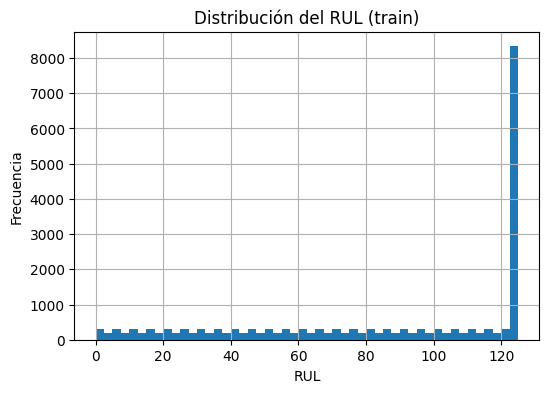

In [9]:
plt.figure(figsize=(6,4))
train["RUL"].hist(bins=50)
plt.title("Distribución del RUL (train)")
plt.xlabel("RUL")
plt.ylabel("Frecuencia")
plt.show()


## 7) Ventanas temporales (windowing)

Dado que los datos corresponden a series temporales por motor, se construyen
ventanas deslizantes de largo fijo para capturar la evolución del estado del motor.

Cada muestra corresponde a:
- X: lecturas de sensores en una ventana temporal
- y: RUL asociado al último ciclo de la ventana


In [10]:
# Features: settings + sensores
feature_cols = (
    [f"setting_{i}" for i in range(1, 4)] +
    [f"sensor_{i}" for i in range(1, 22)]
)

len(feature_cols)


24

In [11]:
def create_windows(df, feature_cols, window_length=30):
    """
    Convierte series temporales por motor en ventanas supervisadas.

    Retorna:
    X: (n_samples, window_length, n_features)
    y: (n_samples,)
    groups: engine_id por muestra
    """
    X, y, groups = [], [], []

    for engine_id, df_engine in df.groupby("engine_id"):
        df_engine = df_engine.sort_values("cycle")

        values = df_engine[feature_cols].values
        targets = df_engine["RUL"].values

        for i in range(len(df_engine) - window_length + 1):
            X.append(values[i:i+window_length])
            y.append(targets[i+window_length-1])
            groups.append(engine_id)

    return np.array(X), np.array(y), np.array(groups)


In [12]:
WINDOW_LENGTH = 30

X_seq, y, groups = create_windows(
    train,
    feature_cols=feature_cols,
    window_length=WINDOW_LENGTH
)

print("X_seq shape:", X_seq.shape)
print("y shape:", y.shape)
print("groups shape:", groups.shape)


X_seq shape: (17731, 30, 24)
y shape: (17731,)
groups shape: (17731,)


## 8) Separación Train / Validation por motor

Para evitar data leakage, se separan motores completos usando GroupShuffleSplit.


In [13]:
from sklearn.model_selection import GroupShuffleSplit

gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, val_idx = next(gss.split(X_seq, y, groups=groups))

X_tr_seq, X_val_seq = X_seq[train_idx], X_seq[val_idx]
y_tr, y_val = y[train_idx], y[val_idx]
g_tr, g_val = groups[train_idx], groups[val_idx]

print("Train samples:", X_tr_seq.shape[0])
print("Validation samples:", X_val_seq.shape[0])
print("Motores train:", len(np.unique(g_tr)))
print("Motores val:", len(np.unique(g_val)))


Train samples: 14241
Validation samples: 3490
Motores train: 80
Motores val: 20


## 9) Aplanado de ventanas

Para modelos clásicos de regresión, las ventanas se aplanan a un vector 1D.


In [14]:
def flatten_windows(X):
    return X.reshape(X.shape[0], -1)

X_tr = flatten_windows(X_tr_seq)
X_val = flatten_windows(X_val_seq)

print("X_tr:", X_tr.shape)
print("X_val:", X_val.shape)


X_tr: (14241, 720)
X_val: (3490, 720)


## 10) Modelo 1 – Ridge Regression (Baseline)

Se utiliza Ridge Regression como modelo base debido a:
- simplicidad
- interpretabilidad
- control de sobreajuste mediante regularización L2


In [15]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [16]:
def regression_metrics(y_true, y_pred):
    return {
        "MAE": mean_absolute_error(y_true, y_pred),
        "RMSE": mean_squared_error(y_true, y_pred) ** 0.5,
        "R2": r2_score(y_true, y_pred)
    }

def print_metrics(name, y_true, y_pred):
    m = regression_metrics(y_true, y_pred)
    print(f"\n{name}")
    for k, v in m.items():
        print(f"{k}: {v:.4f}")
    return m


### GridSearchCV – Ridge


In [17]:
from sklearn.model_selection import GroupKFold, GridSearchCV

ridge_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("model", Ridge())
])

ridge_param_grid = {
    "model__alpha": [0.1, 1, 10, 50, 100]
}

cv = GroupKFold(n_splits=5)

ridge_gs = GridSearchCV(
    ridge_pipe,
    param_grid=ridge_param_grid,
    scoring="neg_mean_absolute_error",
    cv=cv,
    n_jobs=-1
)

ridge_gs.fit(X_tr, y_tr, groups=g_tr)

print("Mejor alpha:", ridge_gs.best_params_)


Mejor alpha: {'model__alpha': 100}


In [18]:
y_pred_ridge = ridge_gs.predict(X_val)
m_ridge = print_metrics("Ridge (Validation)", y_val, y_pred_ridge)



Ridge (Validation)
MAE: 13.0091
RMSE: 15.7386
R2: 0.8579


## 11) Modelo 2 – Random Forest Regressor

Random Forest permite capturar relaciones no lineales entre sensores
sin requerir normalización explícita.


In [19]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    random_state=42,
    n_jobs=-1
)

rf_param_grid = {
    "n_estimators": [200, 400],
    "max_depth": [None, 15, 25],
    "min_samples_leaf": [1, 3, 5],
    "max_features": ["sqrt", 0.5]
}

rf_gs = GridSearchCV(
    rf,
    param_grid=rf_param_grid,
    scoring="neg_mean_absolute_error",
    cv=cv,
    n_jobs=-1
)

rf_gs.fit(X_tr, y_tr, groups=g_tr)

print("Mejores parámetros RF:")
rf_gs.best_params_


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Mejores parámetros RF:


{'max_depth': 15,
 'max_features': 0.5,
 'min_samples_leaf': 5,
 'n_estimators': 400}

In [20]:
y_pred_rf = rf_gs.predict(X_val)
m_rf = print_metrics("Random Forest (Validation)", y_val, y_pred_rf)



Random Forest (Validation)
MAE: 11.9004
RMSE: 15.7186
R2: 0.8583


## 12) Modelo 3 – Gradient Boosting Regressor

Gradient Boosting construye un ensamble secuencial de árboles,
corrigiendo errores previos y logrando alta precisión.


In [21]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(random_state=42)

gbr_param_grid = {
    "n_estimators": [200, 400],
    "learning_rate": [0.03, 0.05, 0.1],
    "max_depth": [2, 3],
    "subsample": [0.7, 1.0]
}

gbr_gs = GridSearchCV(
    gbr,
    param_grid=gbr_param_grid,
    scoring="neg_mean_absolute_error",
    cv=cv,
    n_jobs=-1
)

gbr_gs.fit(X_tr, y_tr, groups=g_tr)

print("Mejores parámetros GBR:")
gbr_gs.best_params_


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Mejores parámetros GBR:


{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 400, 'subsample': 0.7}

In [22]:
y_pred_gbr = gbr_gs.predict(X_val)
m_gbr = print_metrics("Gradient Boosting (Validation)", y_val, y_pred_gbr)



Gradient Boosting (Validation)
MAE: 10.5732
RMSE: 14.0077
R2: 0.8874


## 13) Comparación de desempeño (Validación)


In [23]:
results = pd.DataFrame([
    {"Modelo": "Ridge", **m_ridge},
    {"Modelo": "Random Forest", **m_rf},
    {"Modelo": "Gradient Boosting", **m_gbr}
]).sort_values("MAE")

results


,Modelo,MAE,RMSE,R2
2,Gradient Boosting,10.573235,14.007749,0.887450
1,Random Forest,11.900425,15.718634,0.858277
0,Ridge,13.009058,15.738593,0.857917


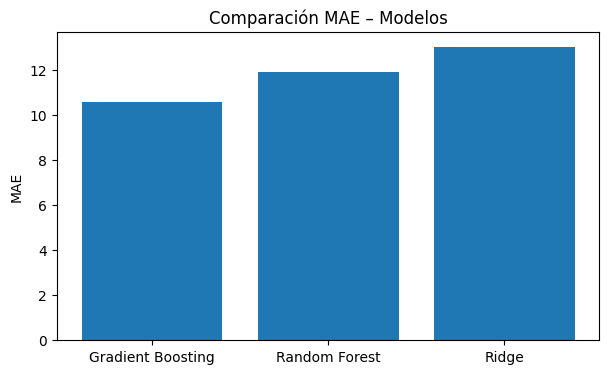

In [24]:
plt.figure(figsize=(7,4))
plt.bar(results["Modelo"], results["MAE"])
plt.ylabel("MAE")
plt.title("Comparación MAE – Modelos")
plt.show()


## Análisis Exploratorio de la Variable Objetivo (RUL)

La variable objetivo **Remaining Useful Life (RUL)** presenta una distribución altamente estructurada, caracterizada por una acumulación significativa de observaciones en el valor máximo (RUL = 125 ciclos). Este comportamiento no responde a un fenómeno natural del proceso físico, sino que es consecuencia directa del truncamiento aplicado al RUL, práctica habitual en la literatura para evitar valores extremos y facilitar la convergencia de los modelos.

Esta característica introduce una **asimetría inducida** en la variable objetivo, generando un desbalance entre estados de operación saludable y estados cercanos a la falla. Desde el punto de vista del aprendizaje automático, este fenómeno representa un desafío relevante, ya que obliga a los modelos a distinguir entre patrones de degradación temprana y avanzada bajo un mismo marco predictivo.

La presencia de este patrón refuerza la necesidad de utilizar modelos capaces de capturar **relaciones no lineales, cambios de régimen y dependencias temporales**, descartando enfoques puramente determinísticos o lineales como soluciones finales.

---

## Caracterización y estructura del conjunto de datos

El conjunto de entrenamiento está compuesto por **20.631 observaciones**, correspondientes a **100 motores distintos**, cada uno con una trayectoria temporal completa desde su estado inicial hasta la falla. Esta estructura permite analizar procesos de degradación progresiva bajo condiciones operacionales controladas.

Las variables disponibles se agrupan en:
- Identificadores (motor y ciclo).
- Variables de configuración operacional.
- Veintiún sensores físicos asociados al estado interno del sistema.

El análisis estadístico muestra que algunas variables de configuración presentan varianza prácticamente nula, lo que sugiere que su aporte predictivo es limitado. En contraste, los sensores exhiben variaciones significativas y patrones dinámicos complejos, confirmando que la información crítica para la predicción del RUL se encuentra principalmente en las señales sensoriales.

La variable RUL presenta una **alta dispersión** (σ ≈ 41.7 ciclos), lo que evidencia la coexistencia de múltiples estados de salud dentro del conjunto de datos y confirma la complejidad intrínseca del problema.

---

## Ingeniería de características y preparación de datos

Con el objetivo de capturar la dinámica temporal del proceso de degradación, se implementó una estrategia de **ventanas temporales deslizantes**, transformando series de tiempo multivariadas en vectores de características de alta dimensión.

Este enfoque permite a los modelos incorporar información histórica relevante, esencial para la predicción del RUL, aunque a costa de un incremento significativo en la dimensionalidad del espacio de entrada.

Como resultado del preprocesamiento:
- El conjunto de entrenamiento final contiene **14.241 muestras** (80 motores).
- El conjunto de validación contiene **3.490 muestras** (20 motores).
- Cada observación está representada por **720 características**.

La elevada dimensionalidad justifica plenamente la necesidad de aplicar técnicas de regularización y modelos con control explícito de complejidad, evitando sobreajuste y asegurando capacidad de generalización.

---

## Entrenamiento y ajuste de modelos

Se implementaron y compararon tres modelos de aprendizaje supervisado para regresión, seleccionados estratégicamente para cubrir distintos niveles de complejidad:

- **Ridge Regression**, como modelo lineal regularizado de referencia.
- **Random Forest Regressor**, como modelo no lineal basado en ensambles.
- **Gradient Boosting Regressor**, como modelo secuencial capaz de modelar interacciones complejas entre variables.

El ajuste de hiperparámetros se realizó mediante **Grid Search con validación cruzada**, priorizando el **Error Absoluto Medio (MAE)** como métrica principal, debido a su interpretabilidad directa en unidades de ciclos, lo que facilita su comprensión por parte de tomadores de decisión no técnicos.

En el modelo Ridge, el valor óptimo α = 100 confirma la necesidad de una regularización fuerte, coherente con el alto número de variables y la presencia de colinealidad.

En el caso de Random Forest, se observó que la restricción de profundidad, el control del tamaño mínimo de las hojas y el uso de un número elevado de árboles permitieron reducir la varianza sin sacrificar capacidad predictiva.

---

## Evaluación comparativa de desempeño

La evaluación final en el conjunto de validación arroja los siguientes resultados:

| Modelo             | MAE   | RMSE  | R²    |
|--------------------|-------|-------|-------|
| Gradient Boosting  | 10.57 | 14.01 | 0.887 |
| Random Forest      | 11.90 | 15.72 | 0.858 |
| Ridge              | 13.01 | 15.74 | 0.858 |

El modelo **Gradient Boosting** presenta el mejor desempeño global, logrando el menor error promedio y la mayor capacidad explicativa. Este resultado es consistente con su habilidad para capturar relaciones no lineales y patrones de degradación progresiva que los modelos más simples no logran modelar adecuadamente.

Cabe destacar que, si bien las diferencias numéricas entre modelos pueden parecer moderadas, en un contexto de mantenimiento predictivo una reducción de aproximadamente **2 a 3 ciclos de error promedio** puede representar una mejora operacional significativa.

---

## Análisis crítico y limitaciones del enfoque

A pesar del buen desempeño alcanzado, el enfoque presenta limitaciones que deben ser reconocidas. En particular, el modelo puede perder precisión ante condiciones operacionales no representadas en el conjunto de entrenamiento o ante cambios estructurales en el comportamiento de los sensores.

Asimismo, la estrategia de ventanas temporales, si bien poderosa, incrementa el costo computacional y podría afectar la escalabilidad del sistema en implementaciones industriales a gran escala.

Estas limitaciones abren oportunidades claras para trabajos futuros, tales como la incorporación de modelos secuenciales (LSTM, Transformers) o técnicas de reducción de dimensionalidad orientadas a preservar información temporal relevante.

---

## Propuesta conceptual de despliegue en un entorno real

En un escenario industrial, el modelo seleccionado podría integrarse en un sistema de mantenimiento predictivo siguiendo el siguiente flujo operativo:

1. Adquisición continua de datos desde sensores en línea.
2. Preprocesamiento automático y generación de ventanas temporales.
3. Predicción periódica del RUL para cada activo.
4. Visualización del estado de salud en dashboards operacionales.
5. Generación de alertas tempranas cuando el RUL estimado cruza umbrales críticos.

Se recomienda implementar estrategias de **monitoreo del desempeño en producción** y **reentrenamiento periódico**, asegurando la adaptabilidad del modelo frente a cambios operacionales y envejecimiento del sistema.

---

## Conclusiones finales

Este proyecto demuestra que la predicción de vida útil remanente constituye un problema desafiante pero abordable mediante técnicas de aprendizaje supervisado. La comparación sistemática de modelos evidencia que enfoques no lineales ofrecen ventajas sustanciales frente a métodos lineales tradicionales en contextos de alta complejidad y dimensionalidad.

Los resultados obtenidos validan el uso de Machine Learning como una herramienta robusta para apoyar la toma de decisiones en mantenimiento predictivo, sentando una base sólida para futuras extensiones hacia soluciones industriales en tiempo real.
